In [1]:
# Standard library imports
import random
from pathlib import Path

import matplotlib.colors as colors_mat

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import torch

# Local imports
from load_data import index_to_image_pos, load, load_image_info

# Sisal imports
from sisal.kernel_adapted import kernel_adapted_opt, plot_kernel_adapted
from sisal.plot import Plot
from sisal.solver import Solver
from sisal.utils import normalize_train_test_full_loader_given_index

## Dataset

- **DOI:** [10.35079/HBM393.LXBW.274](https://doi.org/10.35079/HBM393.LXBW.274)  
- **Masks:** [Zenodo](https://zenodo.org/records/17910325)
- **Dataset ID:** VAN0046-LK-3-45-IMS_lipids_pos_multilayer.ome 
- **HuBMAP Portal Link:** [View Dataset](https://portal.hubmapconsortium.org/browse/dataset/f67c4c1ce4d2f2d6e3e1e4a7f6be032f)

In [2]:
# Specify the location of the Kidney data
data_dir = Path(r"../../data/VAN0046-LK-3-45-IMS_lipids_neg_roi=#1_mz=fix")
#data_dir = Path(r"/Users/lgmigas/Documents/DATA/2025_12_Paul_SISAL")

# Load the data
centroids, mask, mask_to_name, pixel_index, mzs = load(data_dir)
# Load image information
_, image_shape, _ = load_image_info(data_dir)
# Create a mapping from index to image position
index_to_image_map = index_to_image_pos(data_dir)

In [3]:
# This will save the kidney model in the current working directory
# Specify the name for saving the model
model_filename = "model_kidney.pth"

In [4]:
train_loader, test_loader, full_index_loader = normalize_train_test_full_loader_given_index(
    centroids, pixel_index, mask, batch_size=32
)

In [5]:
beta = 4
z_dim = 2
in_size = centroids.shape[1]
epochs = 40
device = "cpu"
save_model_epochs = False
save_loss = False
train = True
in_size = centroids.shape[1]

In [6]:
# Set a fixed seed for reproducibility
seed = 9335
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Training SISAL model  

In [7]:
net = Solver(beta, z_dim, in_size, epochs, device, save_model_epochs, save_loss, train)

In [8]:
# The training will take some time.
# The training might finish before the maximum number of epochs if early stopping is triggered.
net.train(train_loader, test_loader, model_filename)

Training model:  28%|██▊       | 11/40 [08:31<22:29, 46.53s/epoch]


PosixPath('model_kidney.pth')

## Plot

In [7]:
p = Plot(model_filename, device, train_loader, test_loader, full_index_loader)

# Remove unlabeled pixels
mask0 = p.label != 0
p.full_latent = p.full_latent[mask0, :]
p.vars = p.vars[mask0, :]
p.label = p.label[mask0]

Computing latent: 100%|██████████| 7427/7427 [00:07<00:00, 953.80batch/s] 


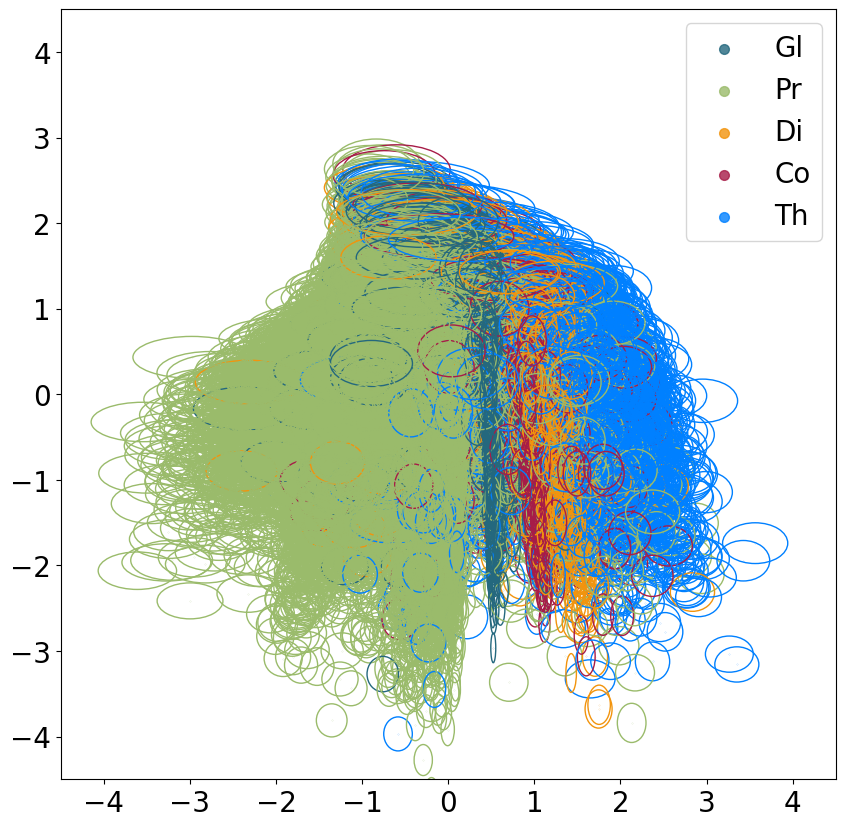

In [8]:
p.plot_latent_dim_with_var(mask_to_name, p=0.6)

## Kernel Density estimation : 

In [9]:
p = Plot(model_filename, device, train_loader, test_loader, full_index_loader)

Computing latent: 100%|██████████| 7427/7427 [00:07<00:00, 933.29batch/s]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, -0.5, 'New Generated Masks')

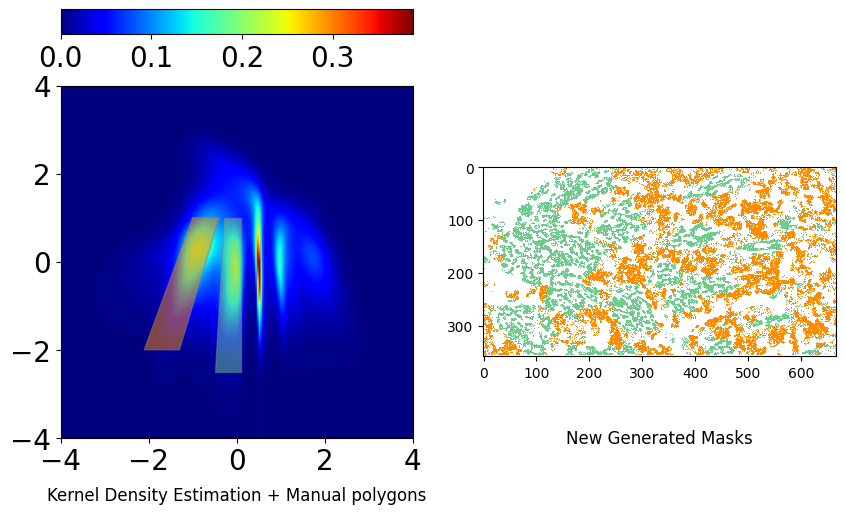

In [10]:
# plot_carving_separate
fig, axs = plt.subplots(figsize=(10, 5), ncols=2)
# Left image
axs[0].tick_params(axis="x", labelsize=20)
axs[0].tick_params(axis="y", labelsize=20)
axs[0].set_title("Kernel Density Estimation + Manual polygons", y=-0.2)
image = kernel_adapted_opt(p.full_latent, p.vars)
plot_kernel_adapted(axs[0], fig, image)


pol_limit1 = [(-2.1, -2), (-1.3, -2), (-0.4, 1), (-1, 1)]  # Orange
pol_limit2 = [(-0.5, -2.5), (0.1, -2.5), (0.1, 1), (-0.3, 1)]  # green
pol_limits = [pol_limit1, pol_limit2]
names = ["pr1", "pr2"]
colors = ["darkorange", "#6DCC8C"]
masks = p.plot_polygons_get_mask(axs[0], pol_limits, colors, index_to_image_map, image_shape)

# Right image (masks)
cmap_col = colors_mat.ListedColormap(["white", *colors])
axs[1].imshow(masks, cmap_col, interpolation="none")
axs[1].set_title("New Generated Masks", y=-0.5)

## Latent traversal subdivision

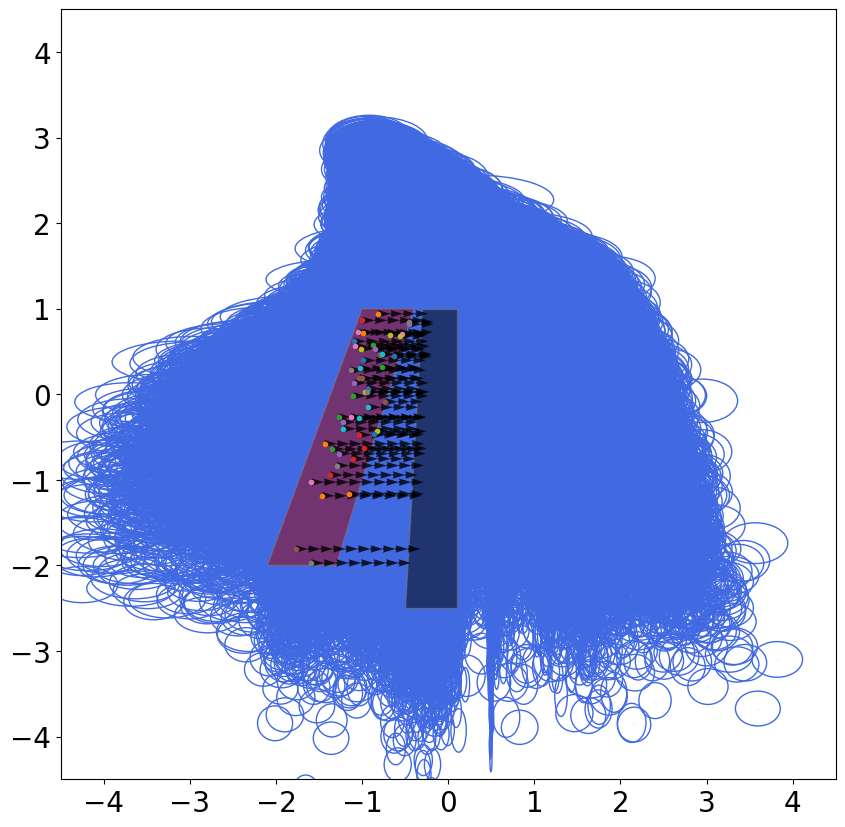

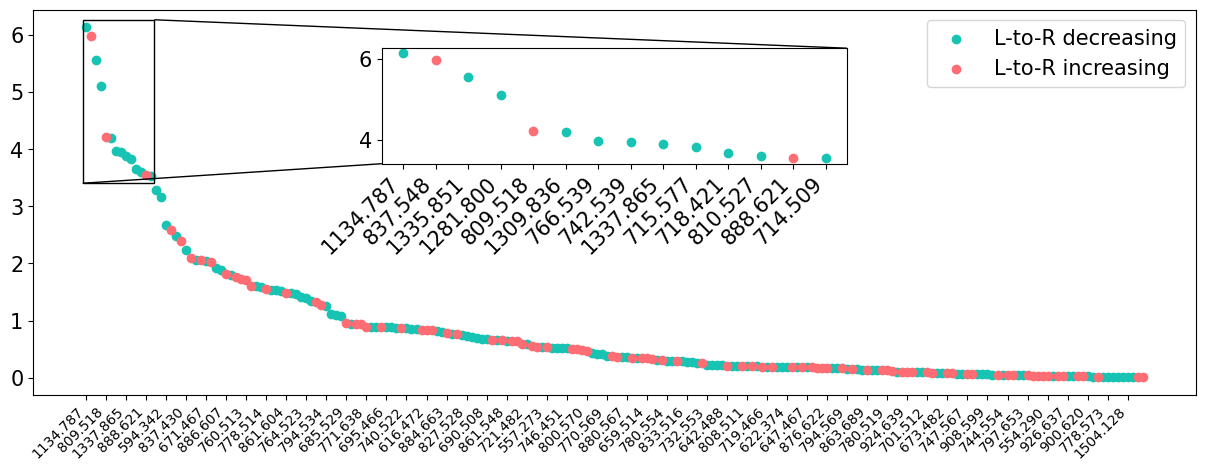

In [11]:
all_points = p.latent_traversal_legs(mask_to_name, pol_limits[0], pol_limits[1])
p.variance_latent_traversal(all_points, mzs, d=centroids.shape[1])